# Assignment: Perceptron and Shallow Neural Network

Kai Hsin Hung | Kaitlyn Elise Yu

### Problem 1 (30 points)
For this problem, you use the data file wine.csv. You will create a model that
will use an optimized set of features to predict the wine quality.

### 1. Use lasso regression to eﬀectively choose the best set of input features. Report these set of features, the value of the coeﬃcients and Eout.

In [42]:
import pandas as pd
import numpy as np

In [43]:
data = pd.read_csv('wine.csv')
data.head()

,Clarity,Aroma,Body,Flavor,Oakiness,Quality
0,1.0,3.3,2.8,3.1,4.1,9.8
1,1.0,4.4,4.9,3.5,3.9,12.6
2,1.0,3.9,5.3,4.8,4.7,11.9
3,1.0,3.9,2.6,3.1,3.6,11.1
4,1.0,5.6,5.1,5.5,5.1,13.3


In [44]:

# Use the first 30 rows for training and the rest for test.
training_data = data[:30]
test_data = data[30:]
features = ['Clarity', 'Aroma', 'Body', 'Flavor', 'Oakiness']
target = 'Quality'

train_x = training_data[features]
train_y = training_data[target]

test_x = test_data[features]
test_y = test_data[target]


# Set up a pipeline 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
Preprocessing = Pipeline(
    steps=[
        ('Normalize', MinMaxScaler()),
    ]
)

In [45]:
Lasso_pipline = Pipeline(
    steps=[
        ("Preprocessing", Preprocessing),
        ('Lasso', Lasso(random_state=42))
    ]
)
Lasso_pipline


Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('Normalize', MinMaxScaler())])),
                ('Lasso', Lasso(random_state=42))])

In [46]:
# Use a grid search with 5 fold cross validation for this regularization
from sklearn.model_selection import GridSearchCV
# parameter range: α = np.logspace(−1,0,3) (lambda)
lasso_params = {'Lasso__alpha': np.logspace(-1, 0, 3),
        }
modelLasso = GridSearchCV(Lasso_pipline, param_grid=lasso_params, scoring='neg_median_absolute_error', cv=5, refit=True)
modelLasso.fit(train_x, train_y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        Pipeline(steps=[('Normalize',
                                                         MinMaxScaler())])),
                                       ('Lasso', Lasso(random_state=42))]),
             param_grid={'Lasso__alpha': array([0.1       , 0.31622777, 1.        ])},
             scoring='neg_median_absolute_error')

In [47]:
print('Original Features:',features)
print('Coefficent Values:', modelLasso.best_estimator_.named_steps.Lasso.coef_)
print('The best value of alpha', modelLasso.best_params_)

from sklearn.metrics import median_absolute_error
lasso_predict = modelLasso.predict(test_x)
print('Eout:', median_absolute_error(test_y, lasso_predict))

Original Features: ['Clarity', 'Aroma', 'Body', 'Flavor', 'Oakiness']
Coefficent Values: [ 0.          2.17998284  0.          3.20927047 -0.        ]
The best value of alpha {'Lasso__alpha': np.float64(0.1)}
Eout: 0.7654000216739183


We can see that ```Aroma``` and ```Flavor``` has more affect than the other features and the base value of alpha is ```0.1```, and we got Eout = ```0.7654000216739183```

### 2. Debias your model. Report the value of the coeﬃcients and Eout. Which one the two models performed better on out of sample points?

In [48]:
from sklearn.linear_model import LinearRegression

# Linear regression pipline
Linear_regression_pipline = Pipeline(
    steps=[
        ('Preprocessing', Preprocessing),
        ('LinearRegression', LinearRegression())
    ]
)
Linear_regression_pipline

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('Normalize', MinMaxScaler())])),
                ('LinearRegression', LinearRegression())])

In [49]:
# with debias (only choose the feature be left after lasso regularization)
left_feature = ['Aroma', 'Flavor']
train_x_left = training_data[left_feature]
test_x_left = test_data[left_feature]
Linear_regression_pipline.fit(train_x_left, train_y)
debias_linear_prediction = Linear_regression_pipline.predict(test_x_left)
print("Eout after debias:", median_absolute_error(test_y, debias_linear_prediction))

Eout after debias: 0.8363251214664924


As a result, we can see the lasso model still have lower Error (```0.7654```) compare to the debias linear model (```0.8363251214664924```) in out of sample data

### 3. Report the final model coeﬃcients. Plot the predicted values vs. actual values.

In [50]:
best_parameter = modelLasso.best_params_['Lasso__alpha']
Lasso_pipline.set_params(Lasso__alpha=best_parameter)

# Retrain model by using all data
final_model = Lasso_pipline.fit(data.drop(columns=['Quality', 'Clarity', 'Body', 'Oakiness']), data['Quality'])
final_model_predict = Lasso_pipline.predict(data.drop(columns=['Quality', 'Clarity', 'Body', 'Oakiness']))

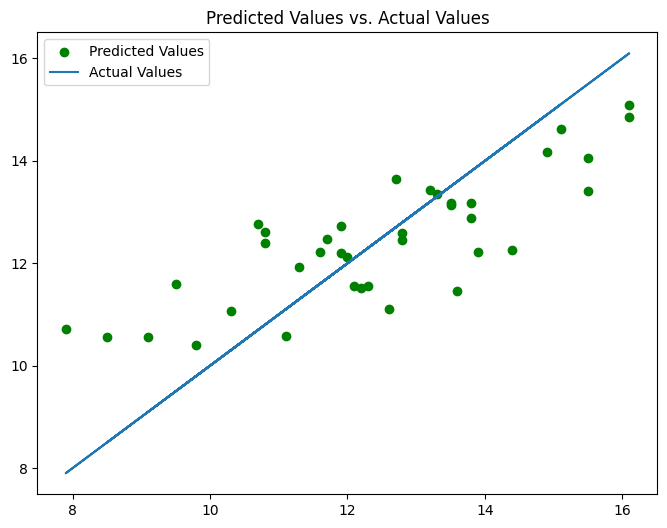

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data['Quality'], final_model_predict, label="Predicted Values", color = 'green')
plt.plot(data['Quality'], data['Quality'], label='Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.legend()
plt.show()

### Problem 2

In this problem you will use the data in siCoData.csv file to train a neural
network. Use the backpropagation algorithm to train a 3-layer (input, hidden,
output) neural network. Use stochastic gradient decent (SGD) technique and
assume that the activation function for the hidden layer and output layer are
tanh and linear, respectively. (You must write your own code for BP and SGD).

#### 1. The stopping criteria for training in this problem should be a combination of achieving a minimum in-sample error 1Ein = N N n=1 en and reaching a maximum number of epochs (In this expression N is the number of observations in the data set and en is the error corresponding to each individual training point). Report the minimum Ein that you could achieve along with the related weights and number of iterations.

In [52]:
data = pd.read_csv('siCoData.csv')
data.head()

,x,y
0,-0.889238,-0.334713
1,0.532539,0.898156
2,0.596540,0.870667
3,-0.375349,-0.713875
4,0.083465,0.401115


In [53]:
X = data['x'].values.reshape(-1, 1)
y = data['y'].values.reshape(-1, 1)
X.shape

(250, 1)

In [54]:
# and tanh function and it's derivative

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2


In [55]:
np.random.seed(42)
# input = bias and x -> two elememts
# output = two hidden layers -> two rows
W1 = np.random.rand(2, 2)

# input bias and two elements -> 3 
# output = to only one output - 1
W2 = np.random.rand(3, 1)

learning_rate = 0.1
max_iterate = 1000


In [56]:
# Add bias
normalize_scaler = MinMaxScaler()
normalize_x = normalize_scaler.fit_transform(X)

X_with_bias = np.column_stack((np.ones((normalize_x.shape[0], 1)), normalize_x))

In [57]:
print("normalize_x shape:", normalize_x.shape)
print("X_with_bias shape:", X_with_bias.shape)
print("W1 shape:", W1.shape)

normalize_x shape: (250, 1)
X_with_bias shape: (250, 2)
W1 shape: (2, 2)


In [58]:
min_Ein = float('inf')
best_iter = 0
best_W1 = 0.0
best_W2 = 0.0
for iterate in range(max_iterate):
    total_error = 0
    for i in range(len(X)):

        # convert it's shape from (2, 0) to (1, 2) row-wise
        x_i = X_with_bias[i].reshape(1, -1)
        y_i = y[i]

        # forward pass
        # input to hidden layer
        S1 = np.dot(x_i, W1)
        S1_tanh= tanh(S1)


        # hidden layer
        # add bias
        S1_tanh_bias = np.hstack((np.ones((1, 1)), S1_tanh))


        S2 = np.dot(S1_tanh_bias, W2)
        y_hat = S2

        # linear (no need to use tanh)
        error = y_hat - y_i
        # unpack array and for calculate mean square error
        total_error += (error ** 2)[0][0]
        # backward pass

        # mean square error = 1/2 (y_hat - y ) ** 2
        # dE / dy_hat = (y_hat - y)
        # dW2 = dE / dW2 = dE/dy_hat * dy_hat / dW2
        # dE/ dy_hat -> (y_hat - y), y_hat -> W2.T @ S1_tanh_bias ->  dy_hat / dW2 = S1_tanh_bias
        # dw2 = (y_hat - y) * S1_tanh_bias
        # S1_tanh_bias form (1, 3) to (3, 1) match the shape of error (1, 1)
        dW2 = np.dot(S1_tanh_bias.T, (2 * error))    


        # dE/dS1_tanh = dE/dy_hat * dy_hat/dS1_tanh * dS1/tanh / dS1
        # W2 exclude the bias from 1
        # W2 from shape (2, 1) to (1, 2) align with error shape (1, 1)
        dS1= np.dot((2 * error), W2[1:].T) * tanh_derivative(S1)
        
        # get dE/dW1
        # to align the shape
        dW1 = np.dot(x_i.T, dS1)

        W2 -= learning_rate * dW2
        W1 -= learning_rate * dW1
    Ein = total_error / len(X)

    if Ein < min_Ein:
        min_Ein = Ein
        best_iter = iterate + 1
        best_W1 = W1
        best_W2 = W2

print(f"Minimun Ein: {min_Ein}, at iteration: {best_iter},\nbest W1:\n {best_W1}\nbest W2:\n {best_W2}")
    

Minimun Ein: 0.051813991622384946, at iteration: 755,
best W1:
 [[-3.46286813 -0.97876014]
 [ 6.84086611  1.96227013]]
best W2:
 [[-0.21596718]
 [ 1.55272521]
 [-1.32282178]]


### 2. Graph the original data (y vs. x) and the predicted values (ˆy vs. x) on two separate scatter plots.

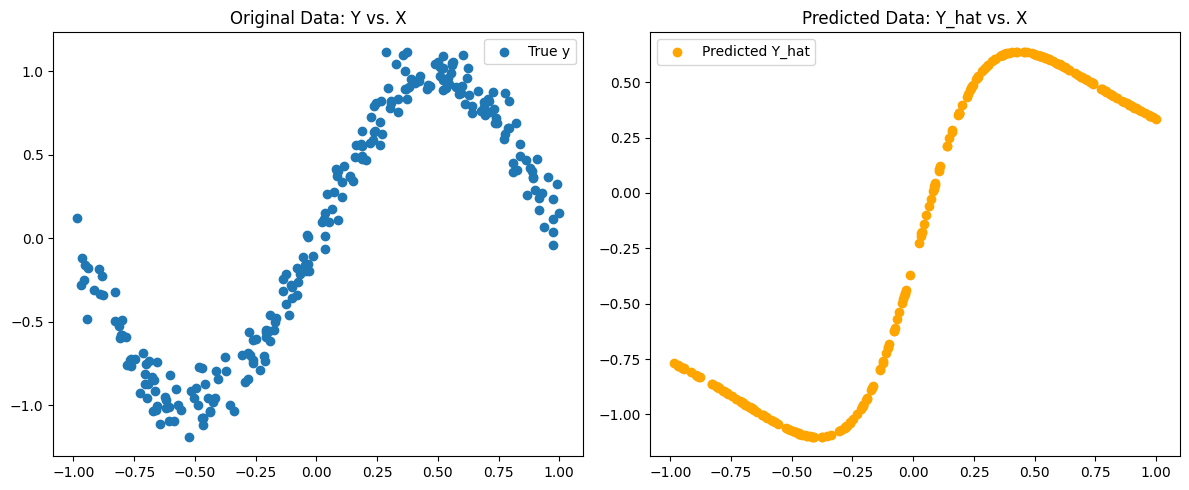

In [61]:
import matplotlib.pyplot as plt
y_predictions = []
# use forward pass to get the prediction
# forward pass
# input to hidden layer
S1 = np.dot(X_with_bias, W1)
S1_tanh= tanh(S1)
# hidden layer
# add bias
S1_tanh_bias = np.hstack((np.ones((S1_tanh.shape[0], 1)), S1_tanh))
S2 = np.dot(S1_tanh_bias, W2)
y_hat = S2
y_predictions.append(y_hat)

plt.figure(figsize=(12, 5))
# Original data
plt.subplot(1, 2, 1)
plt.scatter(X, y, label='True y')
plt.title('Original Data: Y vs. X')
plt.legend()

# Predicted data
plt.subplot(1, 2, 2)
plt.scatter(X, y_predictions, label ='Predicted Y_hat' ,color = 'orange')
plt.title("Predicted Data: Y_hat vs. X")
plt.legend()

plt.tight_layout()
plt.show()
    